<a href="https://colab.research.google.com/github/Abderrahmane-Br/Hybrid-model-for-time-series-forecasting/blob/CNN-LSTM/cnn1d_lstm_slide_size_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [642]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [643]:
# elect_data = pd.read_csv("/content/BrentSpotPrice.csv", index_col="Date")
# elect_data = pd.read_csv("/content/AirPassengers.csv", index_col="Month")
# elect_data = pd.read_csv("/content/Electric_Production.csv", index_col="DATE")
elect_data = pd.read_csv("/content/MedicineData.csv", index_col="date")
# elect_data = pd.read_csv("/content/S&P500.csv", index_col="Date")
# elect_data = pd.read_csv("/content/YearlySunspots.csv", usecols=["time", "value"], index_col="time", parse_dates=True)
# elect_data = pd.read_csv("/content/covid_day_wise.csv", usecols=["Date", "New deaths"], index_col="Date")
# elect_data = pd.read_csv("/content/PDB_Load_History.csv", usecols=["date", "demand"], index_col="date")
# elect_data = pd.read_csv("/content/daily-total-female-births-CA.csv", index_col="date")
# elect_data.index = pd.to_datetime(elect_data.index)


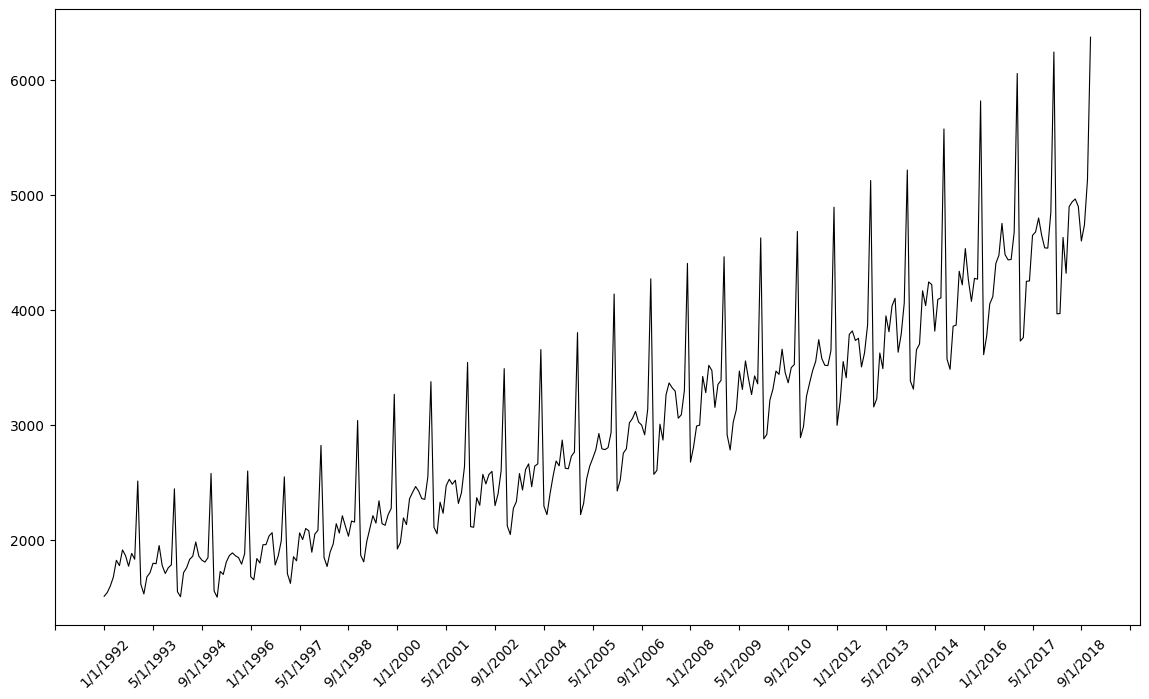

In [644]:
import matplotlib.ticker as ticker
def plot_data(data_axis, data_vals, data_params,title="", xlabel="", ylabel="", legend=[], grid=False):
  plt.rcParams["figure.figsize"] = [14, 8]

  loc_size = int(len(data_axis)*5/100)
  fig, ax = plt.subplots()
  if (loc_size > 0):
    loc = ticker.MultipleLocator(loc_size)
    ax.xaxis.set_major_locator(loc)
  # ax.xaxis.set_minor_locator(min_loc)
  ax.tick_params(colors="black")
  plt.xticks(rotation=45)
  plt.grid(grid)

  for i in range(len(data_vals)):
    style = data_params[i][0]
    color = data_params[i][-1]
    linewidth = data_params[i][-2]
    ax.plot(data_axis, data_vals[i], style, color=color, linewidth=linewidth)

plot_data(elect_data.index, [elect_data.iloc[:,0]], [["-", 0.8, "black"]])

In [645]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(elect_data)
train_scaled = scaler.transform(elect_data)
split_point = int(len(train_scaled) * 0.7)
train_set = torch.tensor(train_scaled[:split_point], dtype=torch.float32)
test_set = torch.tensor(train_scaled[split_point:], dtype=torch.float32)

In [646]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, kernel_size, output_size=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.conv = nn.Conv1d(1, 1, kernel_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input):
        conv_out = self.conv(input.permute(1, 0)).squeeze(0)
        lstm_out, (hidden, cell) = self.lstm(conv_out.view(len(conv_out), 1))
        out = self.linear(lstm_out[-self.output_size:])
        
        return out

In [647]:
def slide(model, optimizer, sequence, lookback, horizon): 

  seq_len = len(sequence)
  results = torch.empty(0)
  i = 0
  while(i <= seq_len - lookback - horizon):
    out = model(sequence[i:i+lookback])
    loss = loss_fun(out, sequence[i+lookback: i+lookback+horizon])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    results = torch.cat((results, out))
    i+= horizon


  # handling last forecast where the horizon goes beyond sequence length

  extra_len = horizon - (seq_len - lookback) % horizon
  out = model(sequence[i:i+lookback])[:-extra_len]
  loss = loss_fun(out, sequence[i+lookback:i+lookback+horizon-extra_len])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  results = torch.cat((results, out))

  return results

In [804]:
lookback = 20
horizon = 8
model = CNN_LSTM(1, 25, 1, 4, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_fun = nn.MSELoss()
epochs = 250

In [805]:
test_tn = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20], dtype=torch.float32).reshape(-1, 1)
results = []
train_error = []
for epoch in range(epochs): 
  # results = np.array(slide(model, optimizer, test_tn, lookback, horizon).detach())
  results = np.array(slide(model, optimizer, train_set, lookback, horizon).detach())
  train_error.append(np.mean(train_scaled[lookback:split_point]-results))

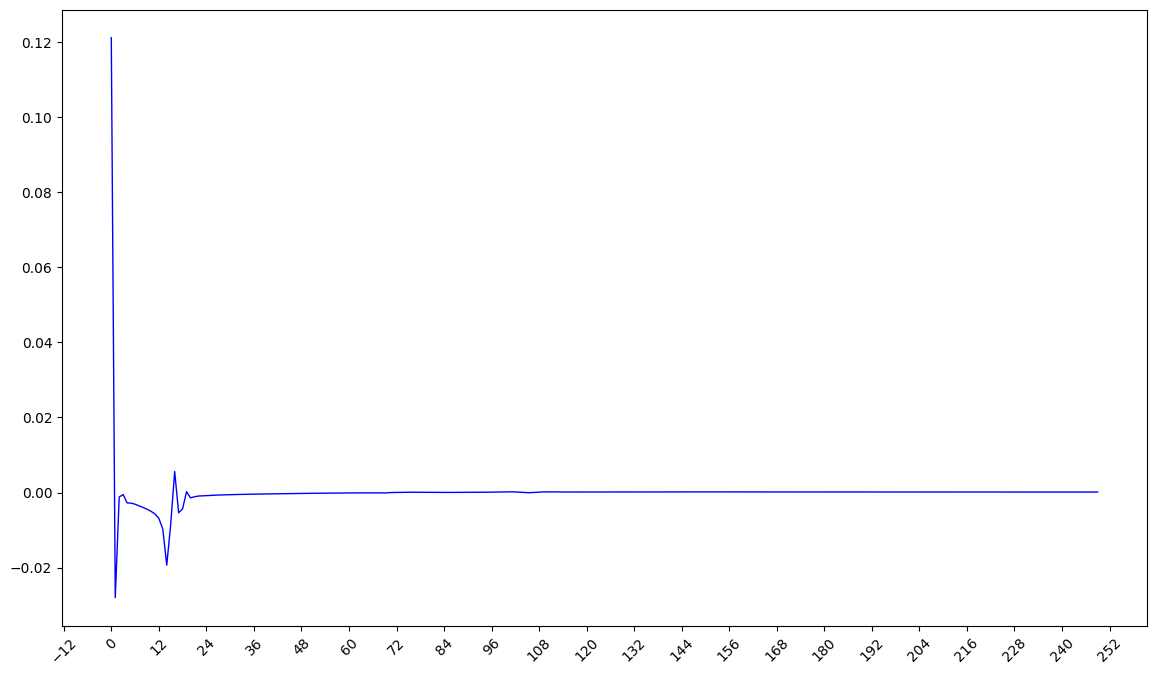

In [806]:
plot_data(np.arange(epochs), [train_error], [["-", 1, "blue"]])

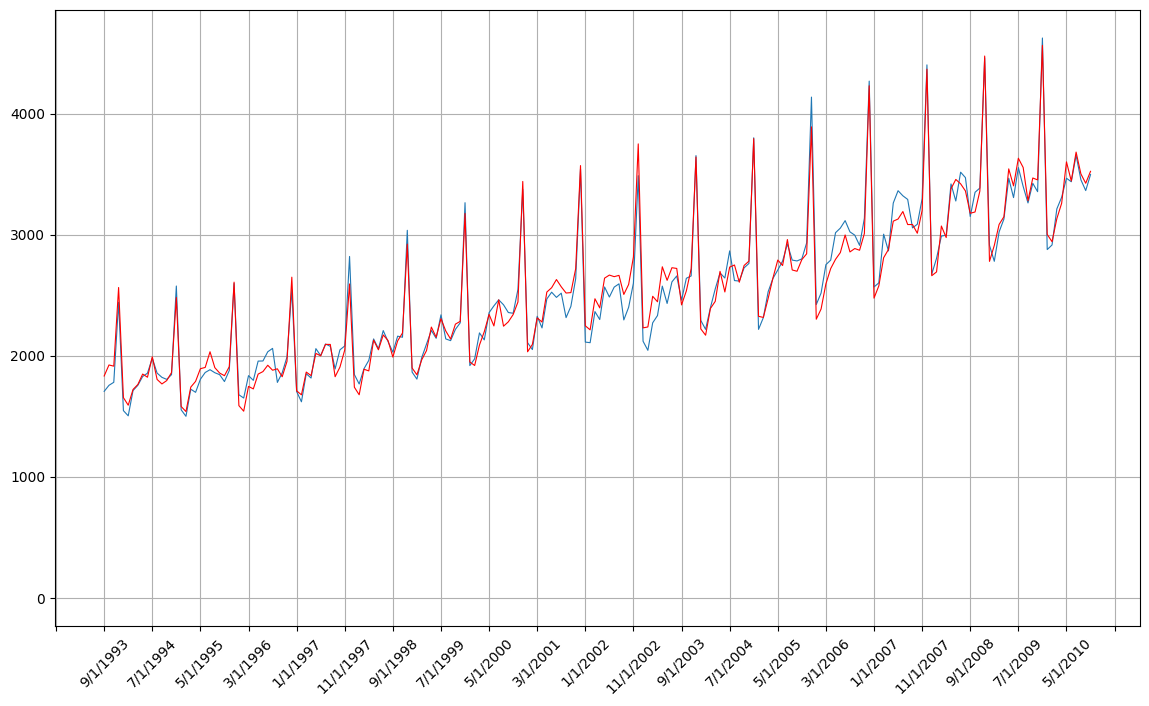

In [807]:
scaled_res = scaler.inverse_transform(np.array(results).reshape(-1, 1)).squeeze(-1)
original_data =elect_data.iloc[:,0][lookback:split_point]
data_index = index=elect_data.index[lookback:split_point]
plot_params = [[0.8, None], [0.8, "red"]]
legend = ["Actual", "Pred"]
plot_data(data_index, [original_data, scaled_res], plot_params, legend=legend, grid=True)
plt.rcParams["figure.figsize"] = [18, 5]

In [808]:
slide_test_set = torch.cat((train_set[-lookback:], test_set))
slide_test_out = slide(model, optimizer, slide_test_set, lookback, horizon).detach()

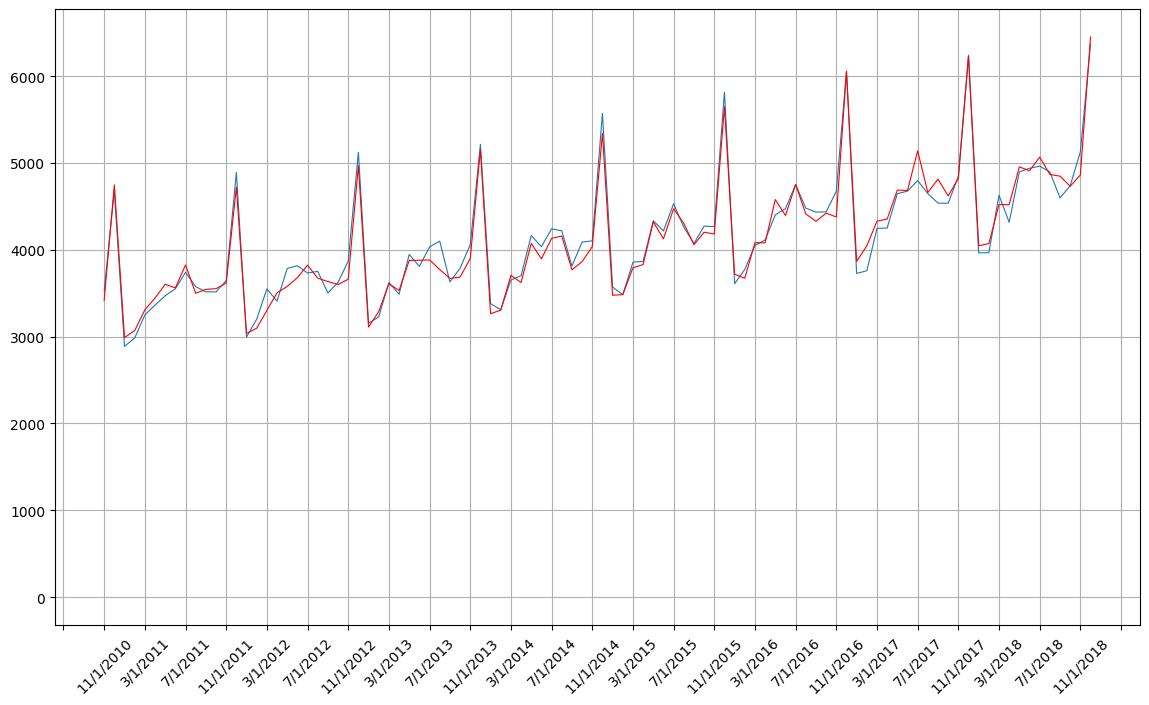

In [809]:
scaled_res = scaler.inverse_transform(np.array(slide_test_out).reshape(-1, 1))
original_data =elect_data.iloc[:,0][split_point:]
data_index = index=elect_data.index[split_point:]
plot_params = [[0.8, None], [0.8, "red"]]
legend = ["Actual", "Pred"]
plot_data(data_index, [original_data, scaled_res], plot_params, legend=legend, grid=True)


In [810]:
# con = nn.Conv1d(1, 1, 3)
# tn = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32)
# out = con(tn.unsqueeze(0))
# print(out.squeeze(0))

In [811]:
# lstm = nn.LSTM(1, 5, 1)
# tn = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
# out, _ = lstm(tn.view(6, 1))
# print(out)

# lin = nn.Linear(5, 1)
# print(lin(out))


In [812]:
from math import sqrt

def calc_errors(actual, pred):
  mse = np.mean((actual - pred) **2)
  mrse = sqrt(mse)
  mae = np.mean(np.abs(actual - pred))
  mape = np.mean((actual - pred)/actual)

  return {"MSE": mse, "MRSE": mrse, "MAE": mae, "MAPE": mape}


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def calc_errors_skl(actual, pred):
  mse = mean_squared_error(actual, pred)
  mrse = sqrt(mse)
  mae = mean_absolute_error(actual, pred)
  mape = mean_absolute_percentage_error(actual, pred)

  return {"MSE": mse, "MRSE": mrse, "MAE": mae, "MAPE": mape}

print(calc_errors(np.array(test_set), np.array(slide_test_out)))

{'MSE': 0.0006444246, 'MRSE': 0.025385519119547593, 'MAE': 0.019796573, 'MAPE': 0.0048050014}


In [813]:

# Covid new deaths lb=15 h=5, 250 epochs, sliding-size=h

# lr=0.001, Adam, 2 lstm, k=2 {'MSE': 0.009142636, 'MRSE': 0.0956171340371852, 'MAE': 0.07104815, 'MAPE': 0.015748119}
# lr=0.001, Adam, 2 lstm, k=3 {'MSE': 0.008673331, 'MRSE': 0.09313071871806226, 'MAE': 0.065397434, 'MAPE': 0.04495691}
# lr=0.001, Adam, 2 lstm, k=4 {'MSE': 0.009350855, 'MRSE': 0.09669981852857609, 'MAE': 0.07316298, 'MAPE': 0.026760606}


# lr=0.0008, Adam, 2 lstm, k=4 {'MSE': 0.009310946, 'MRSE': 0.09649324260533546, 'MAE': 0.07228505, 'MAPE': 0.011820839}
# lr=0.0005, Adam, 2 lstm, k=4 {'MSE': 0.008809357, 'MRSE': 0.0938581746584891, 'MAE': 0.06767388, 'MAPE': 0.0017983139}
# lr=0.0003, Adam, 2 lstm, k=4 'MSE': 0.007982952, 'MRSE': 0.0893473647564868, 'MAE': 0.06523088, 'MAPE': 0.024077088}

# lr=0.0003, Adam, 1 lstm, k=4 'MSE': 0.007982952, 'MRSE': 0.0893473647564868, 'MAE': 0.06523088, 'MAPE': 0.024077088}

# lr=0.001, Adam, 1 lstm, k=2 {'MSE': 0.008923191, 'MRSE': 0.09446264153554858, 'MAE': 0.07027654, 'MAPE': 0.006634782}
# lr=0.001, Adam, 1 lstm, k=3 {'MSE': 0.008449, 'MRSE': 0.0919184437772283, 'MAE': 0.066841826, 'MAPE': 0.03149399}
# lr=0.001, Adam, 1 lstm, k=4 {'MSE': 0.0086446805, 'MRSE': 0.09297677394155993, 'MAE': 0.06901514, 'MAPE': 0.0020210275}


In [814]:
#Air passengers, lb=15, h=5, 250 epochs

# lr=0.001, Adam, 2 lstms, k=2 {'MSE': 0.011704179, 'MRSE': 0.10818585609182071, 'MAE': 0.08965785, 'MAPE': 0.041803036}
# lr=0.001, Adam, 2 lstms, k=3 {'MSE': 0.0069502597, 'MRSE': 0.08336821741131621, 'MAE': 0.06860545, 'MAPE': 0.01964029}
# lr=0.001, Adam, 2 lstms, k=4 {'MSE': 0.022222884, 'MRSE': 0.14907341815141856, 'MAE': 0.11147941, 'MAPE': 0.06597722}
# lr=0.001, Adam, 2 lstms, k=5 {'MSE': 0.022222884, 'MRSE': 0.14907341815141856, 'MAE': 0.11147941, 'MAPE': 0.06597722}


In [815]:
#Air passengers, lb=15, h=5, 250 epochs slide-size=h, final test
# lr=0.001, Adam, 2 lstms, k=2 {'MSE': 0.010261174, 'MRSE': 0.10129745451575918, 'MAE': 0.08367718, 'MAPE': 0.052571952}
# lr=0.001, Adam, 2 lstms, k=3 {'MSE': 0.015330678, 'MRSE': 0.12381711453605503, 'MAE': 0.09519731, 'MAPE': 0.025219595}
# lr=0.001, Adam, 2 lstms, k=4 {'MSE': 0.0128823845, 'MRSE': 0.11350059238433642, 'MAE': 0.09479583, 'MAPE': 0.0356829}
# lr=0.001, Adam, 2 lstms, k=5 {'MSE': 0.012407311, 'MRSE': 0.11138811084827897, 'MAE': 0.08969591, 'MAPE': 0.051274236}



# lr=0.001, Adam, 1 lstms, k=2 {'MSE': 0.012299547, 'MRSE': 0.11090332263695778, 'MAE': 0.09459174, 'MAPE': 0.042352356}
# lr=0.001, Adam, 1 lstms, k=3 {'MSE': 0.0076885554, 'MRSE': 0.08768440796868385, 'MAE': 0.070569314, 'MAPE': 0.023261689}**
# lr=0.001, Adam, 1 lstms, k=4 {'MSE': 0.016845904, 'MRSE': 0.12979177281583035, 'MAE': 0.118381985, 'MAPE': 0.065086655}
# lr=0.001, Adam, 1 lstms, k=5 {'MSE': 0.008920444, 'MRSE': 0.09444810308100955, 'MAE': 0.07964757, 'MAPE': 0.026386673}*




In [816]:
#Medicine, lb=20, h=8, 250 epochs slide-size=h, final test

# lr=0.001, Adam, 2 lstms, k=2 {'MSE': 0.0019920354, 'MRSE': 0.044632224057700634, 'MAE': 0.033438273, 'MAPE': 0.009611826}
# lr=0.001, Adam, 2 lstms, k=3 {'MSE': 0.0020343908, 'MRSE': 0.04510422165249152, 'MAE': 0.033657037, 'MAPE': 0.014802189}
# lr=0.001, Adam, 2 lstms, k=4 {'MSE': 0.0028791185, 'MRSE': 0.053657418376618984, 'MAE': 0.040655464, 'MAPE': 0.0102924295}
# lr=0.001, Adam, 2 lstms, k=5 {'MSE': 0.00066769787, 'MRSE': 0.025839850356518514, 'MAE': 0.020765528, 'MAPE': 0.0010708226}*
# lr=0.001, Adam, 2 lstms, k=6 {'MSE': 0.00094212167, 'MRSE': 0.030694000510226284, 'MAE': 0.024756573, 'MAPE': 0.013886456}
# lr=0.001, Adam, 2 lstms, k=7 {'MSE': 0.0010015643, 'MRSE': 0.03164750100998245, 'MAE': 0.024717236, 'MAPE': 0.0131315915}

# lr=0.001, Adam, 1 lstms, k=2 {'MSE': 0.00082416437, 'MRSE': 0.028708263032610974, 'MAE': 0.02258803, 'MAPE': 0.018503983}
# lr=0.001, Adam, 1 lstms, k=3 {'MSE': 0.007211676, 'MRSE': 0.08492158658102376, 'MAE': 0.055695266, 'MAPE': 0.0071245437}
# lr=0.001, Adam, 1 lstms, k=4 {'MSE': 0.0006444246, 'MRSE': 0.025385519119547593, 'MAE': 0.019796573, 'MAPE': 0.0048050014}*
# lr=0.001, Adam, 1 lstms, k=5 {'MSE': 0.0005041356, 'MRSE': 0.022452964611582287, 'MAE': 0.017947884, 'MAPE': 0.0033415882}**


<BarContainer object of 4 artists>

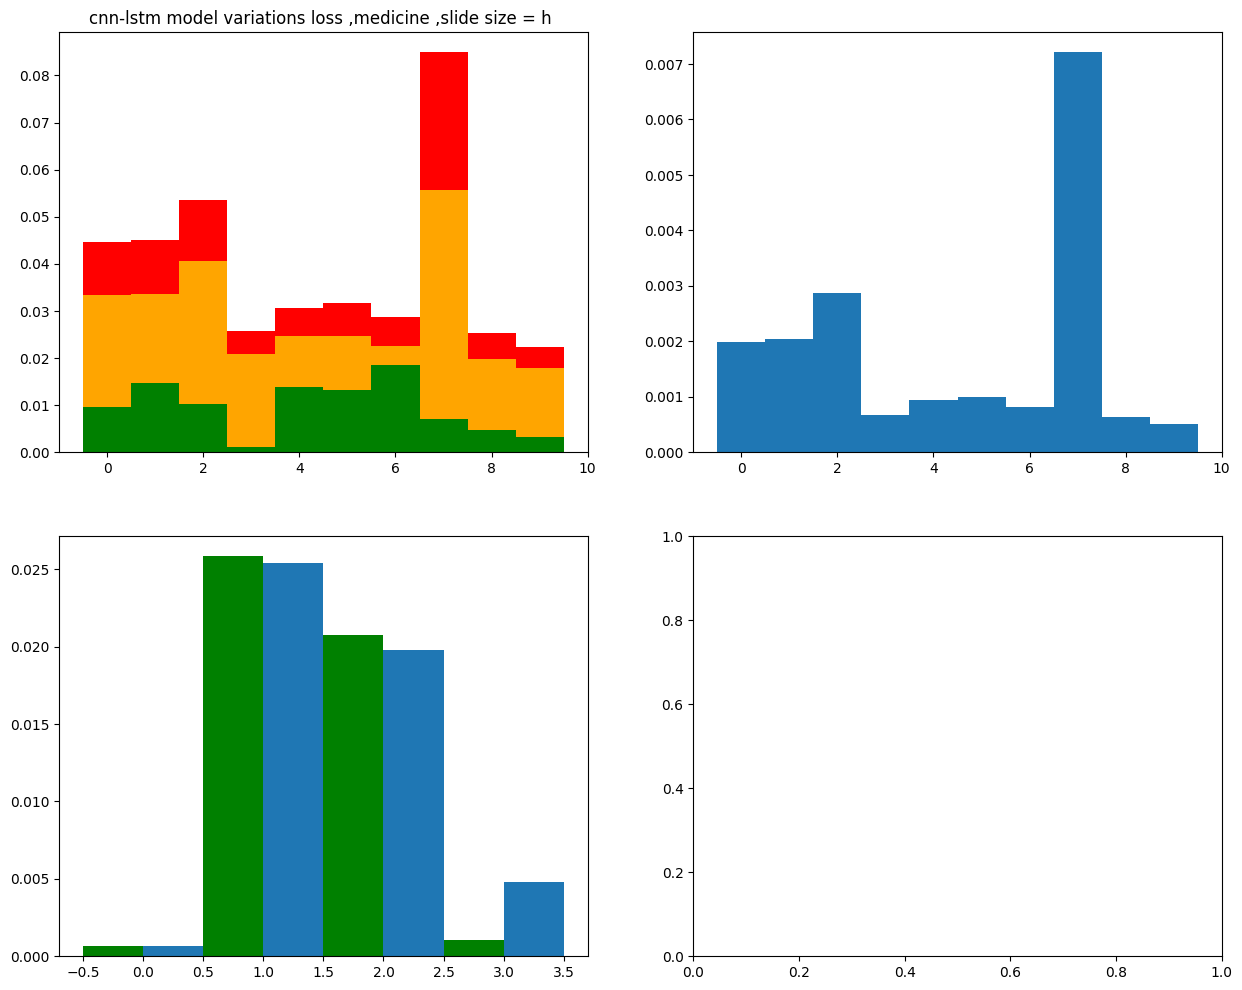

In [891]:
med_err = [
{'MSE': 0.0019920354, 'MRSE': 0.044632224057700634, 'MAE': 0.033438273, 'MAPE': 0.00961182}, 
{'MSE': 0.0020343908, 'MRSE': 0.04510422165249152, 'MAE': 0.033657037, 'MAPE': 0.014802189}, 
{'MSE': 0.0028791185, 'MRSE': 0.053657418376618984, 'MAE': 0.040655464, 'MAPE': 0.01029242}, 
{'MSE': 0.00066769787, 'MRSE': 0.025839850356518514, 'MAE': 0.020765528, 'MAPE': 0.0010708}, 
{'MSE': 0.00094212167, 'MRSE': 0.030694000510226284, 'MAE': 0.024756573, 'MAPE': 0.0138864}, 
{'MSE': 0.0010015643, 'MRSE': 0.03164750100998245, 'MAE': 0.024717236, 'MAPE': 0.013131591},
{'MSE': 0.00082416437, 'MRSE': 0.028708263032610974, 'MAE': 0.02258803, 'MAPE': 0.018503983},
{'MSE': 0.007211676, 'MRSE': 0.08492158658102376, 'MAE': 0.055695266, 'MAPE': 0.0071245437},
{'MSE': 0.0006444246, 'MRSE': 0.025385519119547593, 'MAE': 0.019796573, 'MAPE': 0.0048050014},
{'MSE': 0.0005041356, 'MRSE': 0.022452964611582287, 'MAE': 0.017947884, 'MAPE': 0.0033415882}
]

errs = np.array(list(map(lambda x: list(x.values()), med_err)))
plt.rcParams["figure.figsize"] = [15, 12]
colors = ["blue", "red", "orange", "green"]
figs, axs = plt.subplots(2, 2)
axs[0, 0].title.set_text("cnn-lstm model variations loss ,medicine ,slide size = h ")
for i in range(1,4):
  axs[0, 0].bar(np.arange(len(errs)), errs[:, i], width=1, color=colors[i])
# ax[1]
axs[0, 1].bar(np.arange(len(errs)), errs[:, 0], width=1,)
axs[1, 0].bar(np.arange(4)-0.25, errs[3, :], width=0.5, color="green")
axs[1, 0].bar(np.arange(4)+0.25, errs[-2, :], width=0.5)
# plt.bar(np.arange(len(errs)), errs[:, -1], width=1)

<BarContainer object of 4 artists>

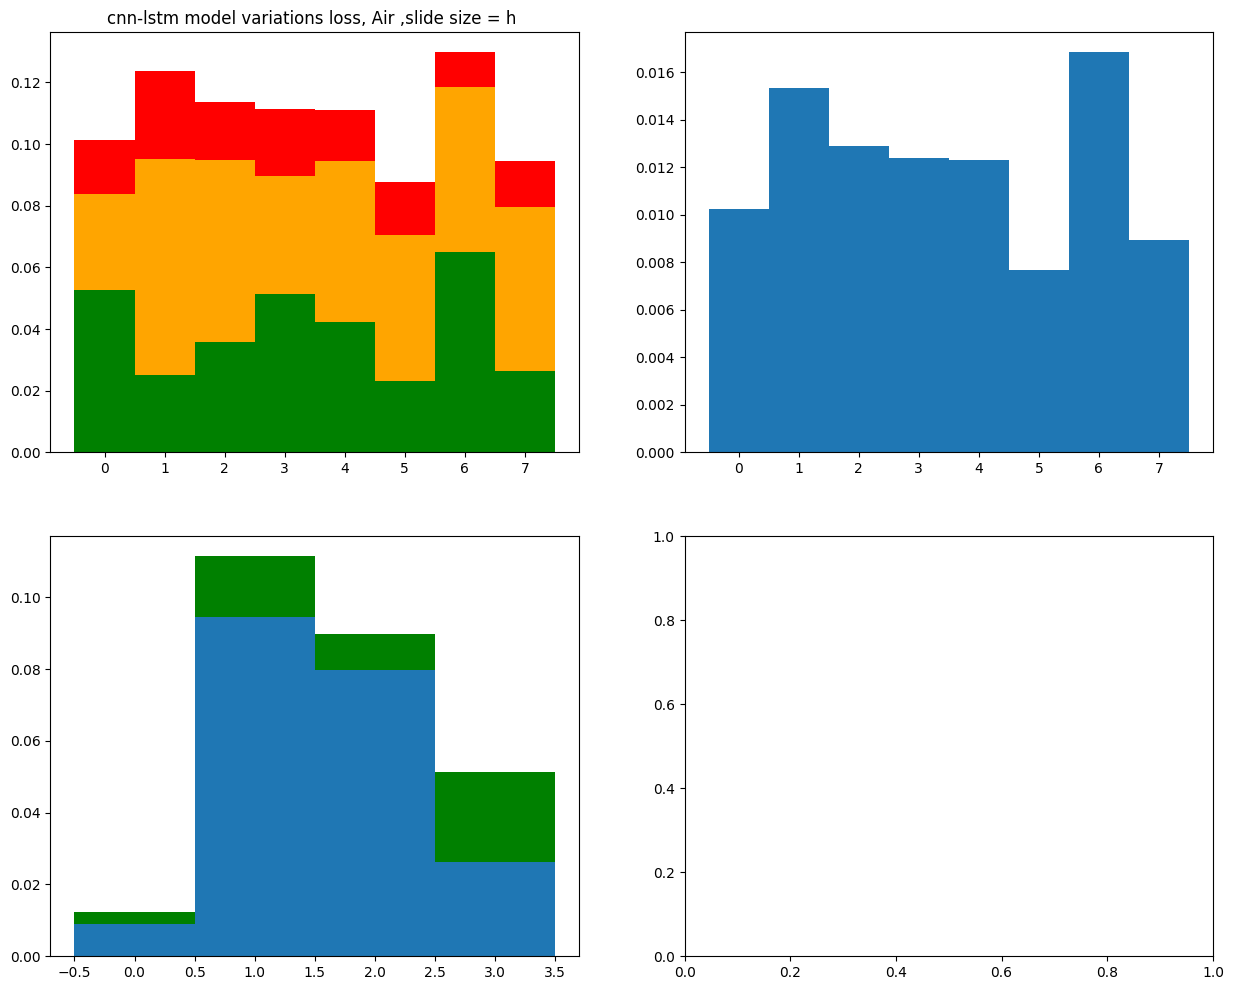

In [883]:
air_err = [
    {'MSE': 0.010261174, 'MRSE': 0.10129745451575918, 'MAE': 0.08367718, 'MAPE': 0.052571952},
{'MSE': 0.015330678, 'MRSE': 0.12381711453605503, 'MAE': 0.09519731, 'MAPE': 0.025219595},
{'MSE': 0.0128823845, 'MRSE': 0.11350059238433642, 'MAE': 0.09479583, 'MAPE': 0.0356829},
{'MSE': 0.012407311, 'MRSE': 0.11138811084827897, 'MAE': 0.08969591, 'MAPE': 0.051274236},
{'MSE': 0.012299547, 'MRSE': 0.11090332263695778, 'MAE': 0.09459174, 'MAPE': 0.042352356},
{'MSE': 0.0076885554, 'MRSE': 0.08768440796868385, 'MAE': 0.070569314, 'MAPE': 0.023261689},
{'MSE': 0.016845904, 'MRSE': 0.12979177281583035, 'MAE': 0.118381985, 'MAPE': 0.065086655},
{'MSE': 0.008920444, 'MRSE': 0.09444810308100955, 'MAE': 0.07964757, 'MAPE': 0.026386673}
]

errs = np.array(list(map(lambda x: list(x.values()), air_err)))
plt.rcParams["figure.figsize"] = [15, 12]
colors = ["blue", "red", "orange", "green"]
figs, axs = plt.subplots(2, 2)
axs[0, 0].title.set_text("cnn-lstm model variations loss, Air ,slide size = h ")
for i in range(1,4):
  axs[0, 0].bar(np.arange(len(errs)), errs[:, i], width=1, color=colors[i])
# ax[1]
axs[0, 1].bar(np.arange(len(errs)), errs[:, 0], width=1,)
axs[1, 0].bar(np.arange(4), errs[3, :], width=1, color="green")
axs[1, 0].bar(np.arange(4), errs[-1, :], width=1)
# plt.bar(np.arange(len(errs)), errs[:, -1], width=1)

Text(0.5, 1.0, 'covid new deaths dataset')

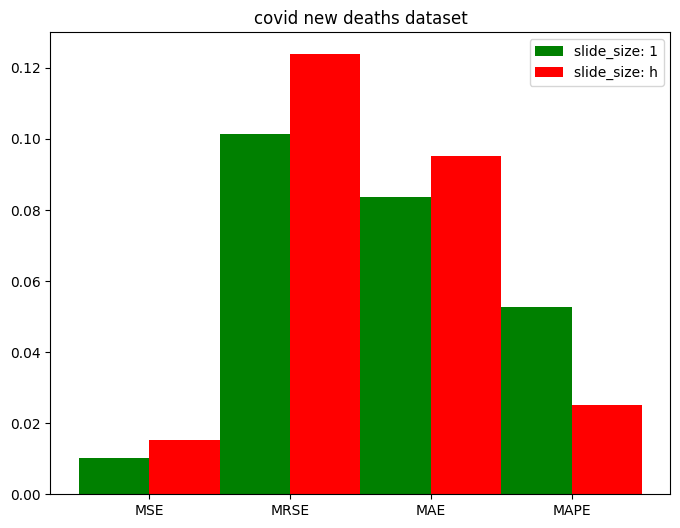

In [915]:
cov_com = [
    {'MSE': 0.007809382, 'MRSE': 0.08837070743193237, 'MAE': 0.06564393, 'MAPE': 0.025032274},
    {'MSE': 0.008469265, 'MRSE': 0.09202860943385234, 'MAE': 0.06828674, 'MAPE': 0.0022406117}
]
plt.rcParams["figure.figsize"] = [8, 6]
errs = np.array(list(map(lambda x: list(x.values()), air_err)))
plt.bar(np.arange(4)-0.25, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.25, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("covid new deaths dataset")

Text(0.5, 1.0, 'air passengers dataset')

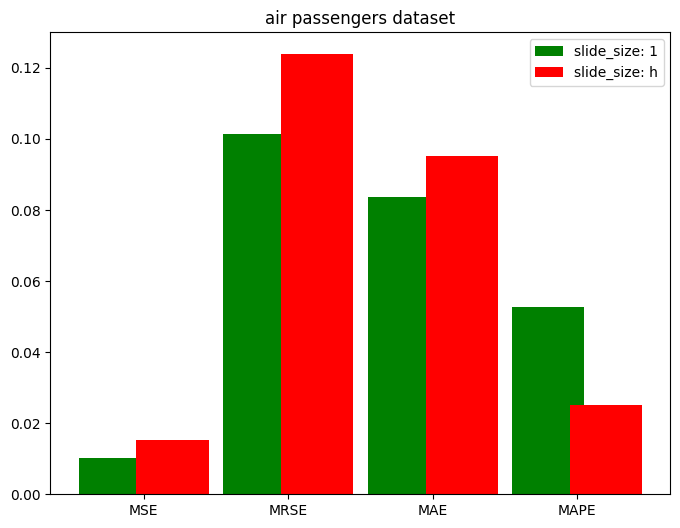

In [914]:
air_com = [
    {'MSE': 0.0020295498, 'MRSE': 0.04505052492628952, 'MAE': 0.03671508, 'MAPE': 0.025323546},
    {'MSE': 0.0076885554, 'MRSE': 0.08768440796868385, 'MAE': 0.070569314, 'MAPE': 0.023261689}
]
plt.rcParams["figure.figsize"] = [8, 6]
errs = np.array(list(map(lambda x: list(x.values()), air_err)))
plt.bar(np.arange(4)-0.2, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.2, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("air passengers dataset")

Text(0.5, 1.0, 'medicine sales dataset dataset')

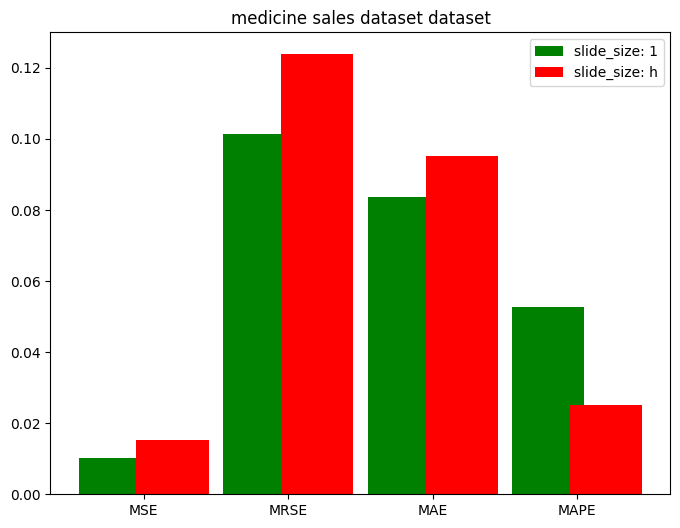

In [913]:
medc_com = [
    {'MSE': 0.00044222464, 'MRSE': 0.021029137928812777, 'MAE': 0.017099291, 'MAPE': 0.0111910375},
    {'MSE': 0.0005041356, 'MRSE': 0.022452964611582287, 'MAE': 0.017947884, 'MAPE': 0.0033415882}
]
errs = np.array(list(map(lambda x: list(x.values()), air_err)))

plt.rcParams["figure.figsize"] = [8, 6]
plt.bar(np.arange(4)-0.2, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.2, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("medicine sales dataset dataset")